# PTO on GE
## Some GE symbolic regression problems

In this notebook we quickly visualise the results from PTO-GE on some symbolic regression problems. We have some problems defined by datasets, and then some problems defined by random generation of coefficients in polynomials.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import seaborn as sns
%matplotlib inline

def count_nodes(s): return 1 + s.count(",") + s.count("(")

# Problems from datasets

We have:

* 5 problem instances (Pagie 2D, Dow Chemical, Tower, Housing, Vladislavleva 4).
* 4 solvers (RS, HC, LA, EA)
* 2 generators (generating a random string by making a random choice at each non-terminal in the grammar recursively: we have the grammar in BNF format and an "executable" format).
* 2 trace types (linear and structured).

Our budget of evaluations is 20000. We carry out each combination of parameters 30 times. 

Our results will be:

* Objective function value -- that is training fitness. (We have results on unseen data also but it is not visualised for now.) It is the negative of the RMSE. Higher is better.
* Node count in the best solution. Lower is better.

We simply use boxplots to visualise the results. Boxplots appear decisive: no statistical tests are needed.

Each figure represents the results of one problem instance. Within each figure, four boxplots represent the combinations of (solver, trace type).

The **overall conclusion** is that the RS is the worst, EA second-worst, and the two hill-climbing approaches (HC and LA) the best. The structured trace makes a big improvement in all cases -- sometimes clear-cut and sometimes better but still overlapping with the linear trace. There are a couple of cases where the EA with linear trace is worse than RS.

**Generators**: one possible explanation for the poor EA performance is that the naive generator (a simple recursive grammar derivation function, using a BNF grammar just as in previous implementations of GE) does not allow PTO to capture problem structure. Therefore, we implement a second generator (an "executable" grammar where each non-terminal is a random function, as in `test_tracer.py`). To compare the results, compare the first (BNF grammar) and second (executable grammar) plots in each problem. The results are identical (not just similar but identical) for all problems and setups *except* the EA with structured trace. For this setup, the executable grammar gives a small but noticeable improvement. (For each problem, compare ('EA', 1) in the first plot with ('EA', 1) in the second plot.) With this improvement, EA is still worse than HC approaches.

The total runtime for the "original" algorithm was less than an hour on a 24-core 24Gb RAM Mac Pro with Ubuntu Linux. 

Boxplots are created and shown below. Further results are discussed after.

In [2]:
filenames = ["GE_results.dat"]
problems = [
    "Pagie2D",
    "DowNorm",
    "HousingNorm",
    "TowerNorm",
    "Vladislavleva4"
    ]
generators = ["BNF", "exec"]


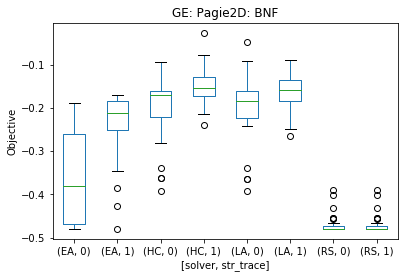

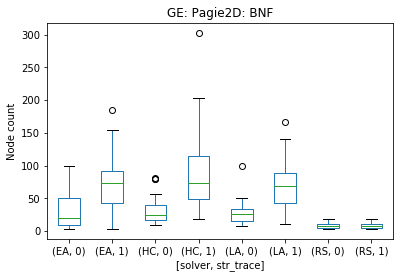

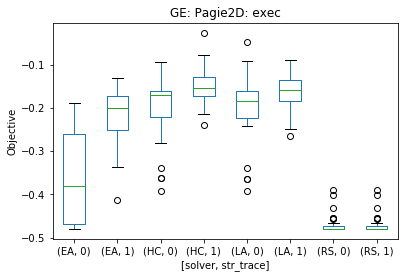

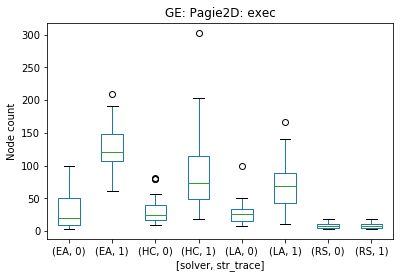

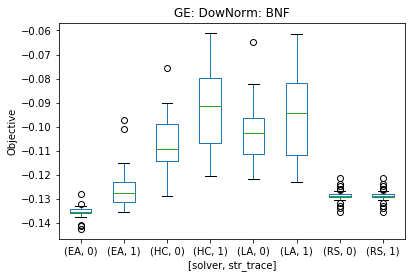

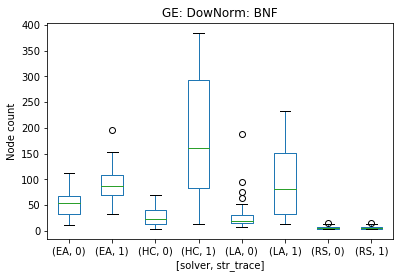

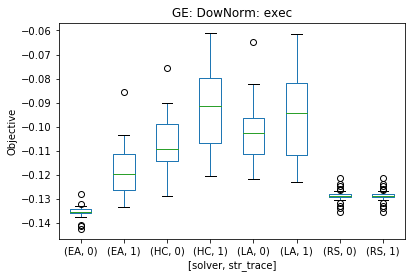

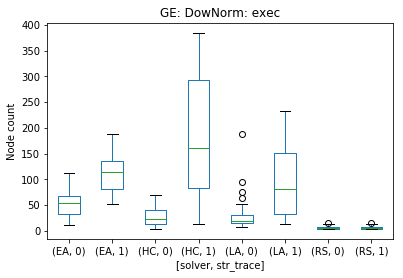

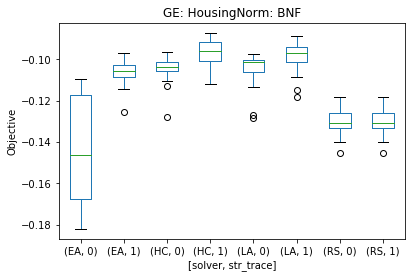

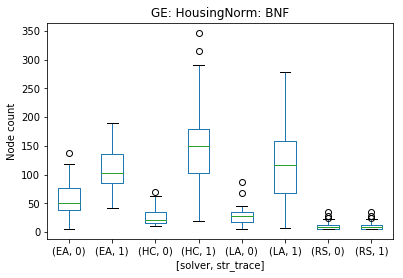

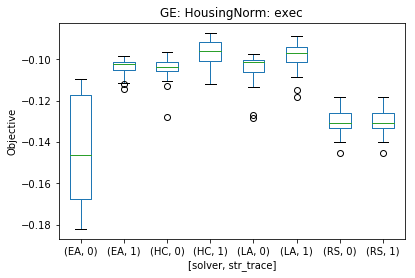

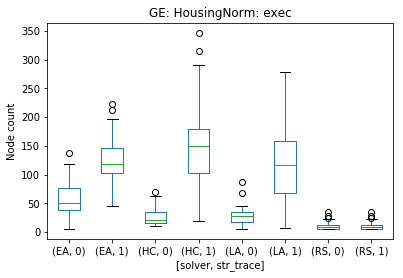

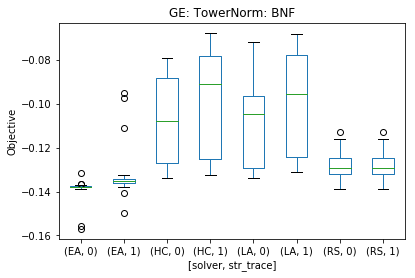

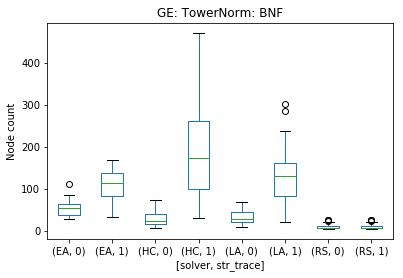

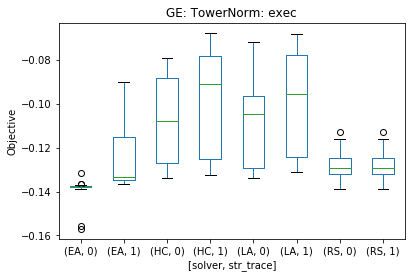

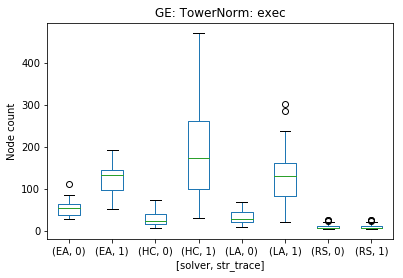

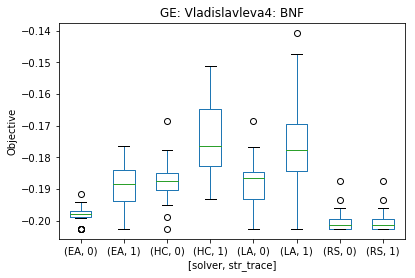

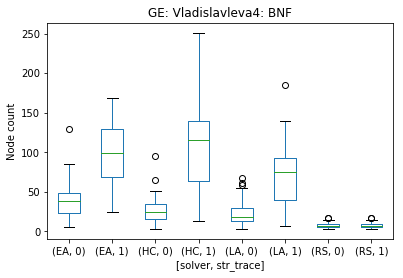

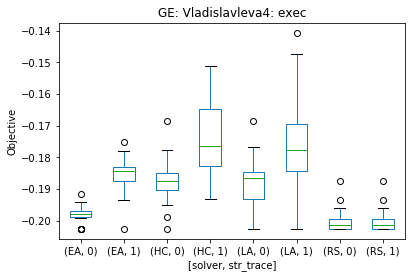

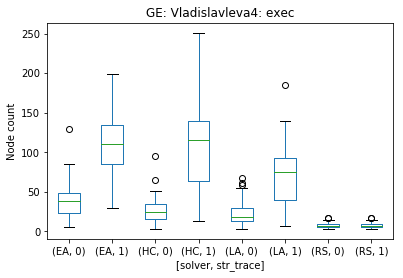

In [22]:
for filename in filenames:
    d = pd.read_csv(filename, delimiter="\t", 
                    names=["problem", "grammar", "solver", "generator", "str_trace", "budget", "rep", "obj", "test_obj", "fn"])
    # shorten the names
    d.loc[d["generator"] == "GE_randsol", "generator"] = "BNF"
    d.loc[d["generator"] == "GE_randsol_sr_nobnf", "generator"] = "exec"
    d["node_count"] = d.apply(lambda row: count_nodes(row.fn), axis=1)
    
    for problem in problems:
        for generator in generators:
            d[(d["problem"] == problem) & (d["generator"] == generator)].boxplot(
                column="obj", by=["solver", "str_trace"], grid=False)
            plt.title(": ".join(("GE", problem, generator)))
            plt.suptitle("")
            plt.ylabel("Objective")
            
            d[(d["problem"] == problem) & (d["generator"] == generator)].boxplot(
                column="node_count", by=["solver", "str_trace"], grid=False)
            plt.title(": ".join(("GE", problem, generator)))
            plt.suptitle("")
            plt.ylabel("Node count")
            

Duplicate avoidance
===

Another possible explanation for the poor EA result is the repetition/duplication of many individuals, which is probably more common in EAs than HC. A simple cache is added to each algorithm to avoid duplicates. Thus, we now have:

* For each solver, a new version with duplicate avoidance
* 1 grammar, because to save runtime, in the folowing experiment we use only the executable grammar.

The **main conclusion** now is that performance is slightly better, but not decisively. When we add duplicate-avoidance, individuals become much larger, because they are forced out of the part of the space where all individuals are small. Memory usage grows hugely: more than 2Gb per run. Fewer runs can be run simultaneously on our 24-core server, so this in combination with the longer time needed to carry out extra mutations means runtime is now several days.

In [23]:
# in the experiment with duplicate avoidance,
# we only used the "executable" grammar, not the bnf
filenames = ["GE_duplicate_results.dat"]
generators = ["exec"]


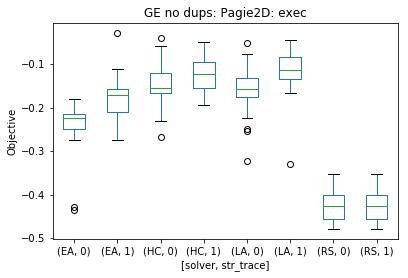

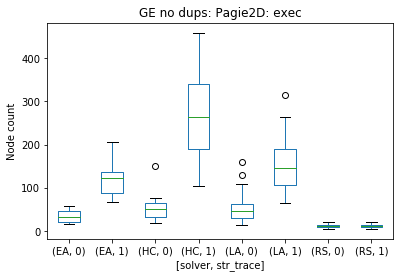

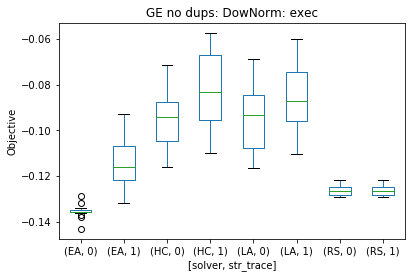

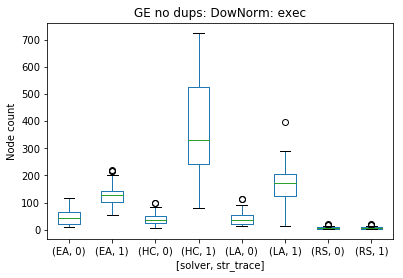

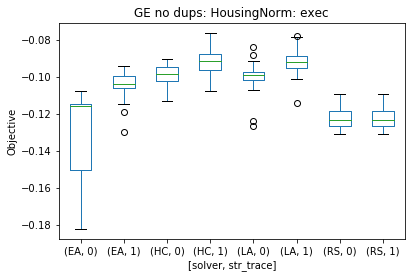

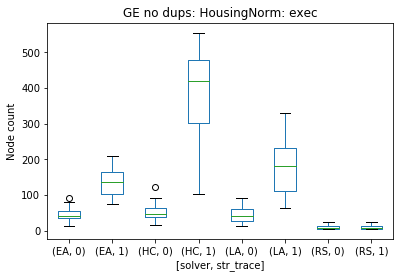

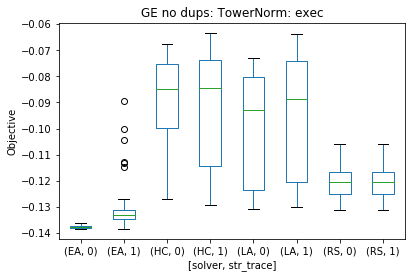

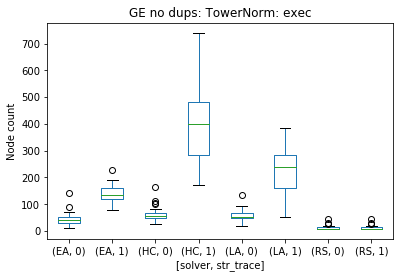

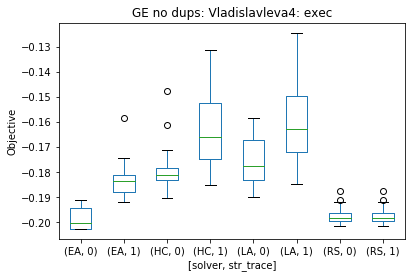

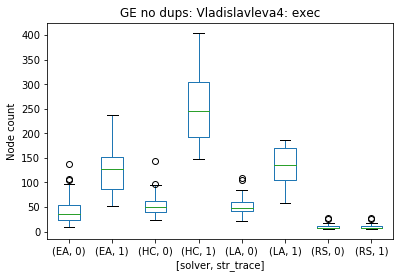

In [24]:
for filename in filenames:
    d = pd.read_csv(filename, delimiter="\t", 
                    names=["problem", "grammar", "solver", "generator", "str_trace", "budget", "rep", "obj", "test_obj", "fn"])
    # shorten the names
    d.loc[d["generator"] == "GE_randsol", "generator"] = "BNF"
    d.loc[d["generator"] == "GE_randsol_sr_nobnf", "generator"] = "exec"
    d["node_count"] = d.apply(lambda row: count_nodes(row.fn), axis=1)
    
    for problem in problems:
        for generator in generators:
            d[(d["problem"] == problem) & (d["generator"] == generator)].boxplot(
                column="obj", by=["solver", "str_trace"], grid=False)
            plt.title(": ".join(("GE no dups", problem, generator)))
            plt.suptitle("")
            plt.ylabel("Objective")
            
            d[(d["problem"] == problem) & (d["generator"] == generator)].boxplot(
                column="node_count", by=["solver", "str_trace"], grid=False)
            plt.title(": ".join(("GE no dups", problem, generator)))
            plt.suptitle("")
            plt.ylabel("Node count")
            

Performance by generation
===


Next, we will look at performance by generation, comparing trace types and solvers for their performance during the run. Our suspicion is that EA should beat HC, so if not, perhaps it's because the runs are too short, which may benefit HC, relative to EA. The runs are 20,000 iterations. Based on these results, it does not seem that that is the case: the EA and HC methods are plateau-ing in much the same way.

For each dataset, we show two plots: one for all solvers and structured trace, the other for all solvers and linear trace. The structured trace is **much** better than linear for EA. The gap is smaller but still **decisively** better for HC and LA. In several cases, the EA with linear trace *stagnates* after about one quarter of the run has elapsed.

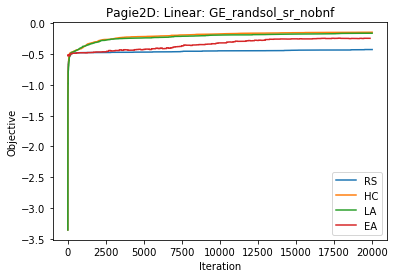

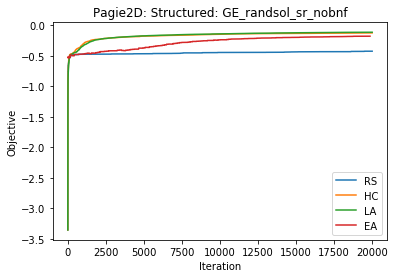

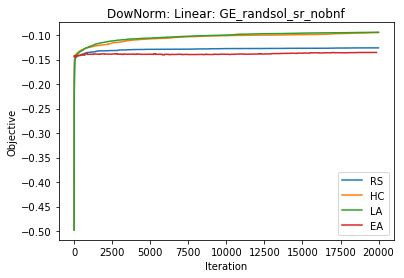

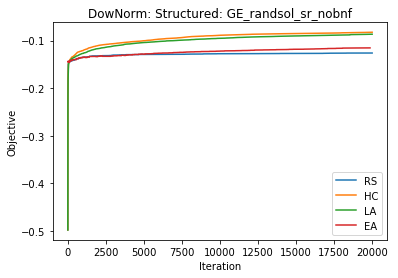

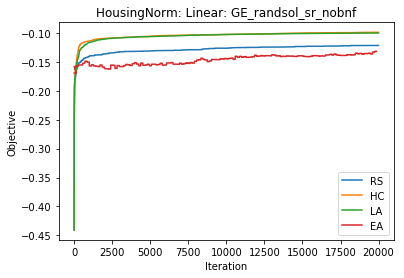

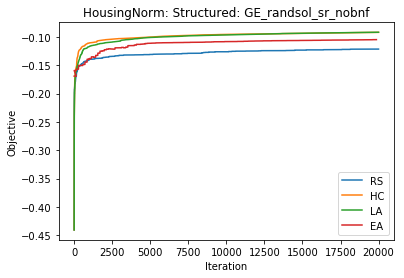

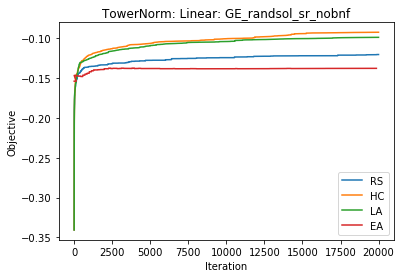

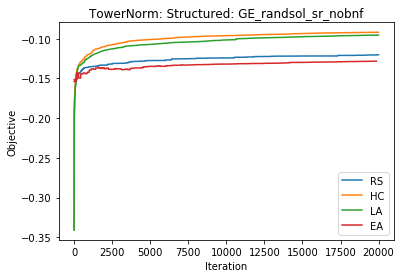

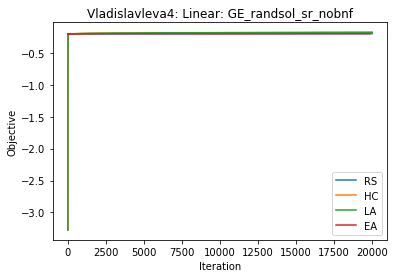

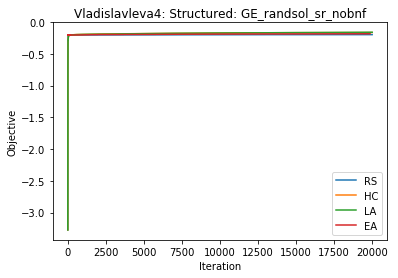

In [7]:
dirname = "/Users/jmmcd/Desktop/GE_duplicate_results_gens"

problems = [
    "Pagie2D",
    "DowNorm",
    "HousingNorm",
    "TowerNorm",
    "Vladislavleva4"
    ]
grammar_file = "sr.bnf"
generators = ["GE_randsol_sr_nobnf"]
solvers = ["RS", "HC", "LA", "EA"]
str_traces = [False, True]
reps = 30
budget = 20000

for problem in problems:
    for generator in generators:
        for str_trace in str_traces:
            for solver in solvers:
                basename = "_".join((problem, grammar_file, solver, generator, str(int(str_trace)), str(budget)))
                filenames = [basename + "_" + str(rep) + ".gens" for rep in range(reps)]
                
                d = np.array([np.genfromtxt(os.path.join(dirname, filename))[:budget, :] for filename in filenames])
                d = d.mean(axis=0)
                plt.plot(d[:, 0], d[:, 1], label=solver)
                
            plt.title(": ".join((problem, "Structured" if str_trace else "Linear", generator)))
            plt.xlabel("Iteration")
            plt.ylabel("Objective")
            plt.legend()
            plt.show()

# Random polynomials

Next, we consider a set of problems defined by target polynomials. We have the same solvers and trace types as before. We use just the executable grammar, and we switch off duplicate avoidance. The problems are defined as polynomials of $n \in \{1, 2, 3\}$ variables, of degree $d \in \{2, 4, 6, 8, 10, 12, 14, 16, 18, 20\}$. The coefficients for all terms are randomly generated.

**Results**: the *number of variables* ($n$) doesn't make a big difference. The degree does: higher degree is harder. The structured trace helps the EA a lot: with linear trace, it is about the same as random search; with structured trace, it is nearly as good as the hill-climbing approaches. Concerning *node count*: RS always has the smallest node count. Recall the node count is the number of nodes in the best individual per run. We are considering training error only, not unseen data. 

In [8]:
filename = "/Users/jmmcd/Desktop/GE_results_poly.dat"
generators = ["exec"]
problems = ["poly_%d_%d" % (d, n) for d in range(2, 21, 2) for n in range(1, 4)]
solvers = ["RS", "HC", "EA"]

In [9]:
d = pd.read_csv(filename, delimiter="\t", 
                names=["problem", "grammar", "solver", "generator", "str_trace", "budget", "rep", "obj", "test_obj", "fn"])
# shorten the names
d.loc[d["generator"] == "GE_randsol", "generator"] = "BNF"
d.loc[d["generator"] == "GE_randsol_sr_nobnf", "generator"] = "exec"
d["node_count"] = d.apply(lambda row: count_nodes(row.fn), axis=1)

d.head()

,problem,grammar,solver,generator,str_trace,budget,rep,obj,test_obj,fn,node_count
0,poly_2_1,sr.bnf,EA,exec,0,20000,0,-0.102299,-0.097544,"aq(0.9, mul(mul(0.0, mul(add(add(mul(add(add(a...",93
1,poly_2_1,sr.bnf,EA,exec,0,20000,1,-0.054097,-0.099018,"sub(aq(x[0], aq(0.5, sub(x[0], mul(mul(sub(mul...",31
2,poly_2_1,sr.bnf,EA,exec,0,20000,10,-0.009426,-0.007649,"aq(aq(0.2, aq(1.0, mul(sub(mul(add(add(1.0, 0....",17
3,poly_2_1,sr.bnf,EA,exec,0,20000,11,-0.055424,-0.042094,"mul(aq(aq(x[0], aq(0.8, x[0])), aq(0.2, add(x[...",13
4,poly_2_1,sr.bnf,EA,exec,0,20000,12,-0.020583,-0.014283,"mul(aq(x[0], aq(0.8, sub(mul(mul(0.0, 0.4), x[...",15


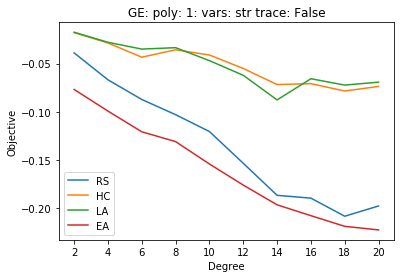

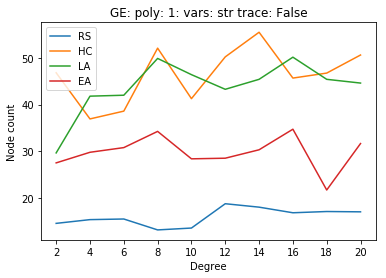

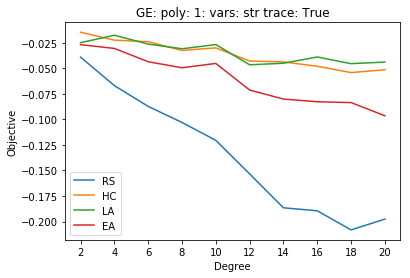

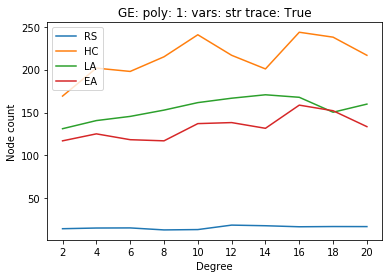

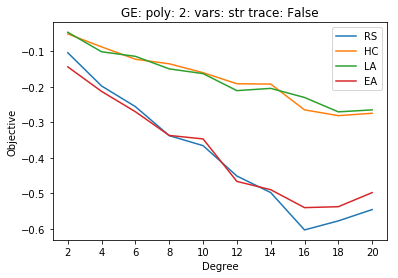

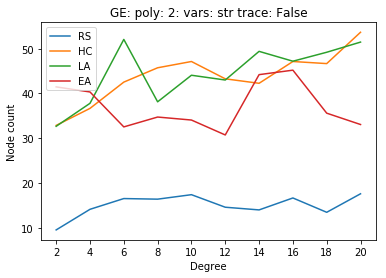

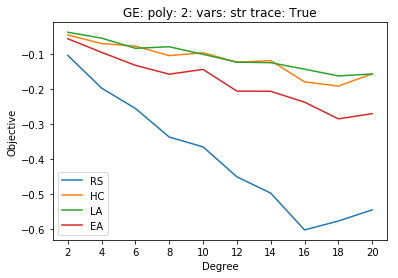

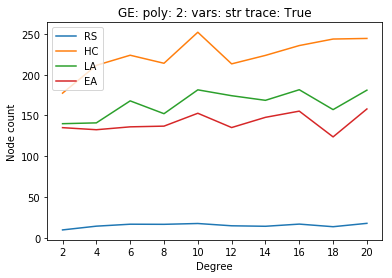

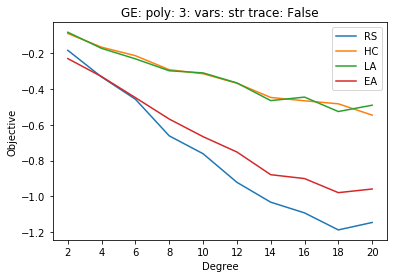

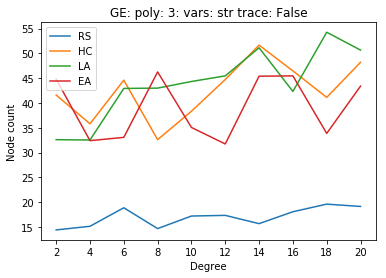

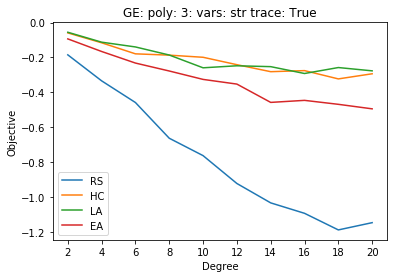

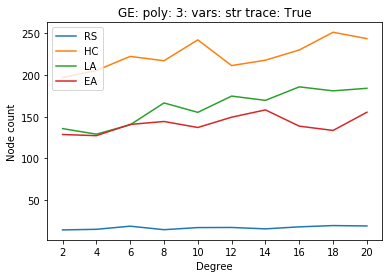

In [34]:
for n in range(1, 4):
    for str_trace in [False, True]:
        for field in ["obj", "node_count"]:
            for solver in solvers:
                x = list(range(2, 21, 2))
                y = [d[
                    (d["problem"] == "poly_%d_%d" % (deg, n)) & 
                    (d["solver"] == solver) &
                    (d["str_trace"] == str_trace)
                      ][field].mean() for deg in x]
                plt.plot(x, y, label=solver)
                plt.title(": ".join(("GE", "poly", str(n), "vars", "str trace", str(str_trace))))
                if field == "obj": plt.ylabel("Objective")
                else: plt.ylabel("Node count")
                plt.xlabel("Degree")
                plt.xticks(range(2, 21, 2))
                plt.legend()
            plt.show()

# Random polynomials with more variables

We have a "background hypothesis" that EAs tend to beat HC on harder/larger problems. The above random polynomial results may suggest that large polynomial degree doesn't make EA win, but may suggest that a larger number of variables would help. So, in the following we choose a fixed degree $d=4$, and scale $n\in\{1, ... , 10\}$. The results do show that EA holds a larger advantage over RS as we scale up, but is still disimproving relative to HC.

**Importantly**, the EA, HC and LA methods are considerably better with the structured trace, versus linear trace, when we scale up.

Concerning node-count, the RS still makes smaller solutions, but there isn't a strong effect of scaling with $n$ (perhaps a surprise).

In [108]:
filename = "GE_results_poly_scale_nvars.dat"
generators = ["exec"]
solvers = ["RS", "HC", "EA"]

In [109]:
d = pd.read_csv(filename, delimiter="\t", 
                names=["problem", "grammar", "solver", "generator", "str_trace", "budget", "rep", "obj", "test_obj", "fn"])
# shorten the names
d.loc[d["generator"] == "GE_randsol", "generator"] = "BNF"
d.loc[d["generator"] == "GE_randsol_sr_nobnf", "generator"] = "exec"
d["node_count"] = d.apply(lambda row: count_nodes(row.fn), axis=1)

d.head()

,problem,grammar,solver,generator,str_trace,budget,rep,obj,test_obj,fn,node_count
0,poly_4_10,sr.bnf,EA,exec,0,20000,0,-1.037274,-1.861782,"aq(x[9], mul(0.0, mul(mul(mul(0.1, aq(aq(aq(ad...",57
1,poly_4_10,sr.bnf,EA,exec,0,20000,10,-1.319138,-1.417003,"add(x[1], add(x[4], add(sub(x[8], x[0]), aq(x[...",145
2,poly_4_10,sr.bnf,EA,exec,0,20000,11,-2.189796,-1.759344,"add(add(add(add(x[3], x[2]), x[2]), x[6]), aq(...",137
3,poly_4_10,sr.bnf,EA,exec,0,20000,12,-2.200854,-2.545238,"sub(mul(x[7], x[4]), sub(x[5], sub(x[7], aq(x[...",93
4,poly_4_10,sr.bnf,EA,exec,0,20000,13,-1.445310,-2.359818,"sub(sub(sub(sub(sub(0.0, 0.5), 0.5), add(1.0, ...",25


# A single plot with 3x2 setups for the paper

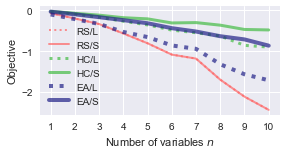

In [110]:
col = {"RS": "#FF6666", "HC": "#44BB44", "EA": "#222288"}
sty = {False: ":", True: "-"}
wid = {"RS": 2, "HC": 3, "EA": 4}

setups = (("RS", False), ("RS", True), ("HC", False), ("HC", True), ("EA", False), ("EA", True))
deg = 4
for solver, str_trace in setups:
    field = "obj"
    x = list(range(1, 11))
    y = [d[
           (d["problem"] == "poly_%d_%d" % (deg, n)) & 
           (d["solver"] == solver) &
           (d["str_trace"] == str_trace)
          ][field].mean() for n in x]
    yerr = [d[
           (d["problem"] == "poly_%d_%d" % (deg, n)) & 
           (d["solver"] == solver) &
           (d["str_trace"] == str_trace)
          ][field].std() for n in x]
    #sns.pointplot(x, y, ci=yerr, dodge=True, label="%s, %s" % (solver, ("Struct" if str_trace else "Lin")))
    plt.errorbar(x, y, yerr=None, lw=wid[solver], linestyle=sty[str_trace], c=col[solver], alpha=.7, label="%s/%s" % (solver, ("S" if str_trace else "L")))
    plt.title("")
    if field == "obj": plt.ylabel("Objective")
    else: plt.ylabel("Node count")
plt.xlabel(r"Number of variables $n$")
plt.xticks(range(1, 11))
plt.legend()
fig = plt.gcf()
fig.set_size_inches(4.2, 2.25)
plt.tight_layout()
plt.savefig("img/GE_polynomials_deg_4_scale_nvars.pdf")
plt.show()

# A single plot of dataset-problems for the paper

In [101]:
filename = "GE_results.dat"
generator = "exec"
problems = [
    "Pagie2D",
    "Vladislavleva4",
    "DowNorm",
    "TowerNorm",
    "HousingNorm",
    ]
prob_names = {
    "Pagie2D": "P-2",
    "DowNorm": "Dow",
    "TowerNorm": "Tow",
    "Vladislavleva4": "V-4",
    "HousingNorm": "Hous",   
}
d = pd.read_csv(filename, delimiter="\t", 
                    names=["problem", "grammar", "solver", "generator", "str_trace", "budget", "rep", "obj", "test_obj", "fn"])
# shorten the names
d.loc[d["generator"] == "GE_randsol", "generator"] = "BNF"
d.loc[d["generator"] == "GE_randsol_sr_nobnf", "generator"] = "exec"
d["node_count"] = d.apply(lambda row: count_nodes(row.fn), axis=1)

RS False
[-0.4689260666666668, -0.2003126333333334, -0.12887070000000003, -0.1282017, -0.13038993333333332]
RS True
[-0.4689260666666668, -0.2003126333333334, -0.12887070000000003, -0.1282017, -0.13038993333333332]
HC False
[-0.2000097, -0.1874755, -0.10676836666666668, -0.10706013333333336, -0.10437516666666664]
HC True
[-0.14684926666666664, -0.1741144, -0.09081863333333334, -0.09863400000000001, -0.0964822]
EA False
[-0.35628716666666665, -0.1980953, -0.1355628, -0.1387728, -0.14545319999999998]
EA True
[-0.21929773333333327, -0.1856238, -0.11871029999999999, -0.12438546666666667, -0.10344010000000001]


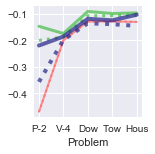

In [107]:
field = "obj"
for solver, str_trace in setups: 
    print(solver, str_trace)
    x = list(range(len(problems)))
    y = [d[
           (d["generator"] == generator) & 
           (d["problem"] == problem) & 
           (d["solver"] == solver) &
           (d["str_trace"] == str_trace)
          ][field].mean()
        for problem in problems]

    print(y)
   
    #y = y.mean()
    plt.errorbar(x, y, yerr=None, lw=wid[solver], linestyle=sty[str_trace], c=col[solver], alpha=.7, label="%s/%s" % (solver, ("Structured" if str_trace else "Linear")))
plt.xlabel("Problem")
plt.xticks(x, [prob_names[problem] for problem in problems])
#plt.legend()
fig = plt.gcf()
fig.set_size_inches(2.25, 2.25)
plt.tight_layout()
plt.savefig("img/GE_dataset_problems.pdf")
plt.show()    

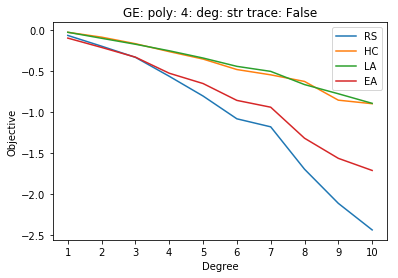

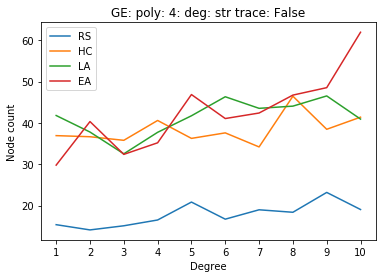

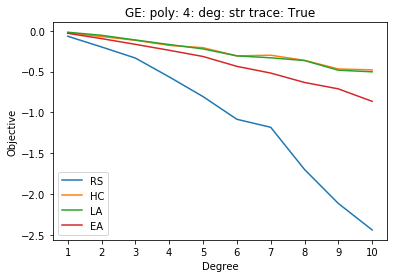

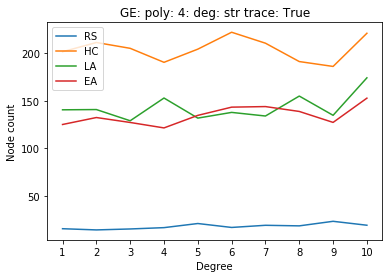

In [15]:
deg = 4

for str_trace in [False, True]:
    for field in ["obj", "node_count"]:
        for solver in solvers:
            x = list(range(1, 11))
            y = [d[
                (d["problem"] == "poly_%d_%d" % (deg, n)) & 
                (d["solver"] == solver) &
                (d["str_trace"] == str_trace)
                  ][field].mean() for n in x]
            plt.plot(x, y, label=solver)
            plt.title(": ".join(("GE", "poly", str(deg), "deg", "str trace", str(str_trace))))
            if field == "obj": plt.ylabel("Objective")
            else: plt.ylabel("Node count")
            plt.xlabel("Degree")
            plt.xticks(range(1, 11))
            plt.legend()
        plt.show()

# Performance by generation (on random polynomials of several variables)

Next we repeat the experiment of comparing trace types and solvers for performance against iteration, this time for random polynomials instead of real-world datasets. The conclusion is similar: it does not appear that the EA will soon pass out the HC methods.

An interesting difference: here, the EA is never worse than RS, whereas with the real-world datasets, it sometimes was.

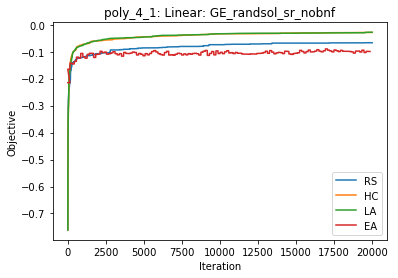

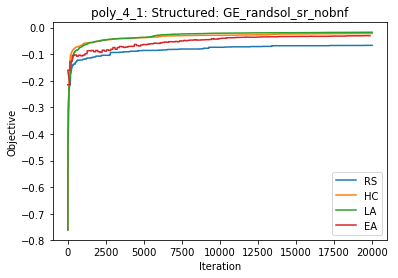

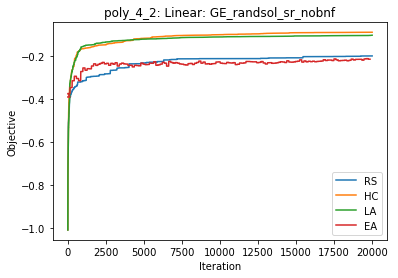

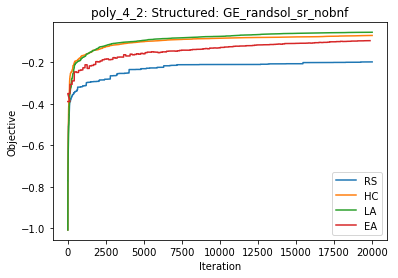

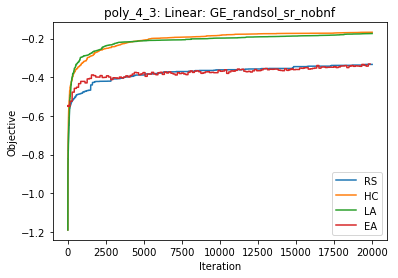

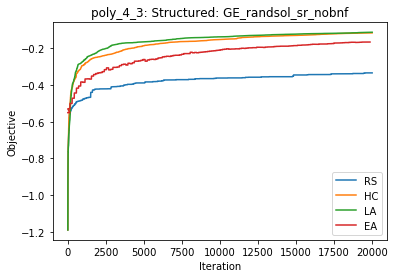

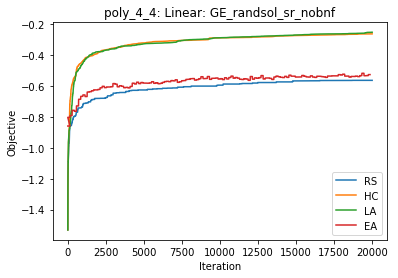

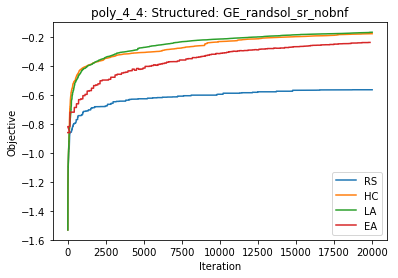

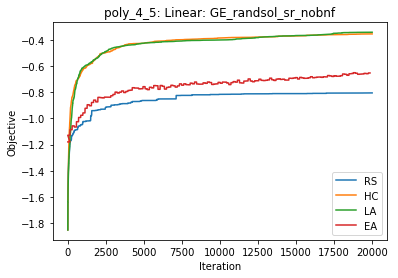

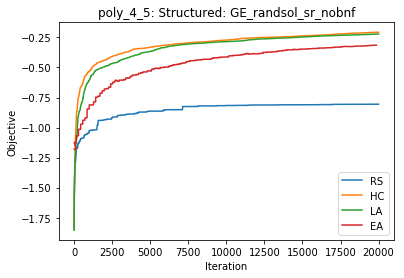

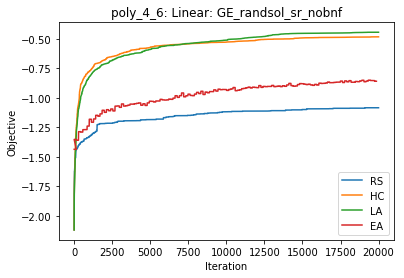

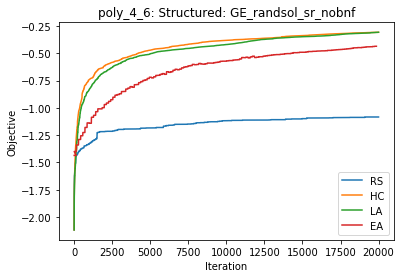

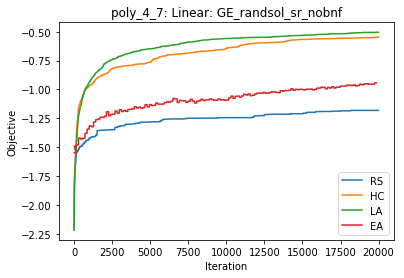

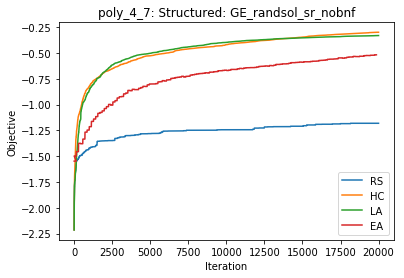

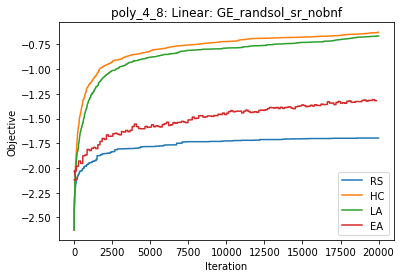

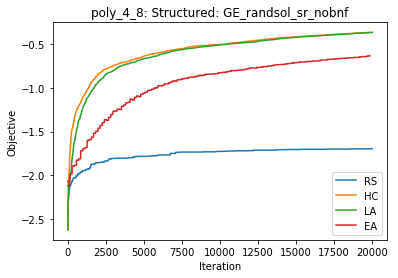

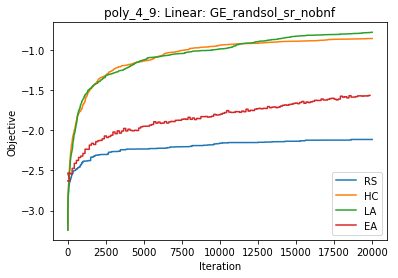

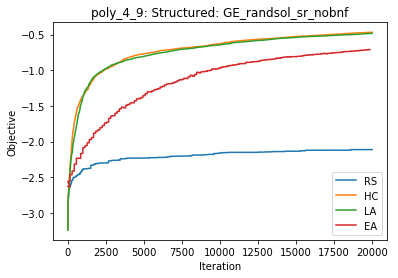

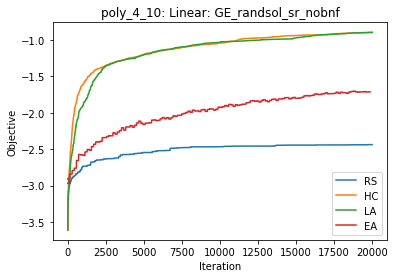

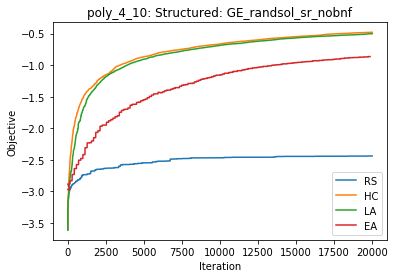

In [6]:
dirname = "/Users/jmmcd/Desktop/GE_results_poly_scale_nvars"

ns = range(1, 11)
deg = 4
grammar_file = "sr.bnf"
generators = ["GE_randsol_sr_nobnf"]
solvers = ["RS", "HC", "LA", "EA"]
str_traces = [False, True]
reps = 30
budget = 20000

for n in ns:
    for generator in generators:
        for str_trace in str_traces:
            for solver in solvers:
                problem = "poly_%d_%d" % (deg, n)

                basename = "_".join((problem, grammar_file, solver, generator, str(int(str_trace)), str(budget)))
                filenames = [basename + "_" + str(rep) + ".gens" for rep in range(reps)]
                
                d = np.array([np.genfromtxt(os.path.join(dirname, filename))[:budget, :] for filename in filenames])
                d = d.mean(axis=0)
                plt.plot(d[:, 0], d[:, 1], label=solver)
                
            plt.title(": ".join((problem, "Structured" if str_trace else "Linear", generator)))
            plt.xlabel("Iteration")
            plt.ylabel("Objective")
            plt.legend()
            plt.show()